In [7]:
from fn_spectralanalysis import *
from fn_basic import readFiles, arrayToDataframe, channelsToRegions

import pandas as pd
import seaborn as sns
import os

**Set the folder of EEG files**

Run the cell to be prompted with an input box for choosing the folder containing the EEG files of interest.

*NB! The path has to be in 'Data\Clean\' folder relative to this notebook.*

In [2]:
exp_folder = input('Experiment folder (e.g., Eyes Open\Baseline):')
#exp_folder = r"Eyes Closed\test"
exp_condition = input('Experiment condition in short (e.g., EO_07)')

clean_folder = r"Data\Clean"
dir_inprogress = os.path.join(clean_folder,exp_folder)

file_dirs, subject_names = readFiles(dir_inprogress,"_clean-epo.fif")

**Conduct spectral analysis on cleaned EEG files and save the results for regionally and channel-by-channel in Excel format**

1. Read raw FIF file (cleaned EEG file)
2. Calculate power spectrum density for the current file
3. Calculate bandpower for each frequency band of interest (delta, theta, alpha, low-beta, high-beta)
4. Plot all the frequency bands topographically
4. Attempt to create a folder and save the bandpowers regionally and channel-by-channel to Excel files

Reading c:\Users\TANIJARV\Downloads\Ketamine-SI project\Data\Clean\Eyes Closed\test\OKTOS_0001_00A_EC_clean-epo.fif ...
    Read a total of 1 projection items:
        EOG-eeg--0.200-0.200-PCA-01 (1 x 32) active
    Found the data of interest:
        t =       0.00 ...    4999.02 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Not setting metadata
52 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
OKTOS_0001_00A_EC Delta MAD error is OK: 1.884
OKTOS_0001_00A_EC Theta MAD error is OK: 1.677
OKTOS_0001_00A_EC Alpha MAD error is OK: 1.426
OKTOS_0001_00A_EC Low-Beta MAD error is OK: 1.401
OKTOS_0001_00A_EC High-Beta MAD error is OK: 1.75
Reading c:\Users\TANIJARV\Downloads\Ketamine-SI project\Data\Clean\Eyes Closed\test\OKTOS_0002_00A_EC_clean-epo.fif ...


C:\Users\TANIJARV\AppData\Local\Temp\ipykernel_14168\2370222181.py:62: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  clb = fig.colorbar(im, cax=cbar_ax)


    Read a total of 1 projection items:
        EOG-eeg--0.200-0.200-PCA-01 (1 x 32) active
    Found the data of interest:
        t =       0.00 ...    4999.02 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Not setting metadata
47 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
OKTOS_0002_00A_EC Delta MAD error is OK: 1.482
OKTOS_0002_00A_EC Theta MAD error is OK: 1.443
OKTOS_0002_00A_EC Alpha MAD error is OK: 1.177
OKTOS_0002_00A_EC Low-Beta MAD error is OK: 1.314
OKTOS_0002_00A_EC High-Beta MAD error is OK: 1.238


C:\Users\TANIJARV\AppData\Local\Temp\ipykernel_14168\2370222181.py:62: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  clb = fig.colorbar(im, cax=cbar_ax)


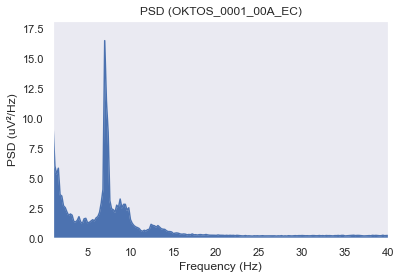

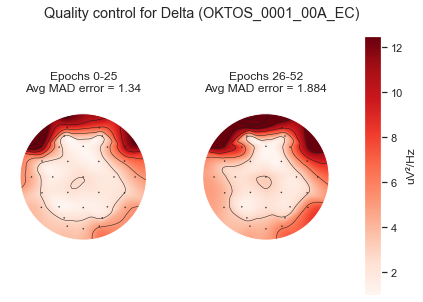

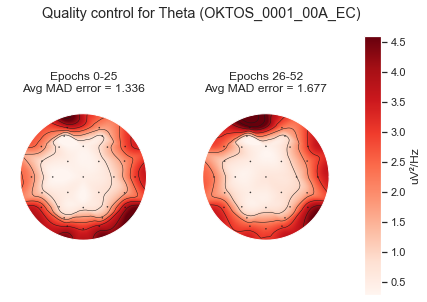

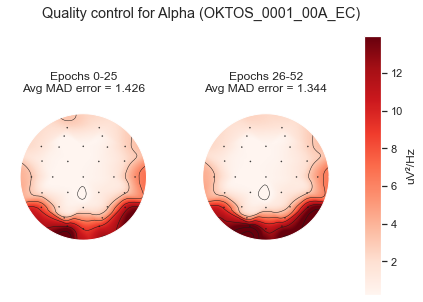

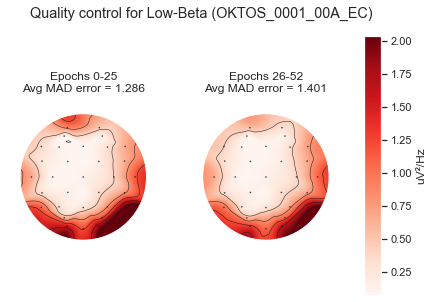

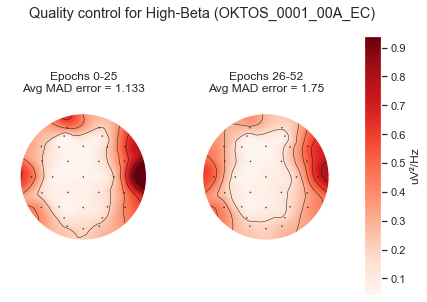

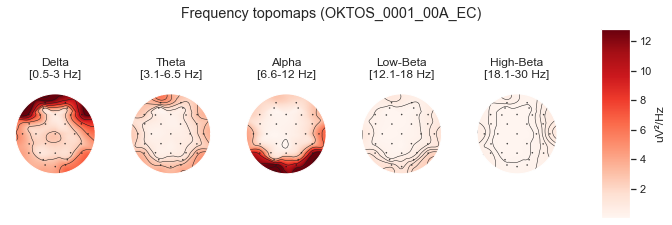

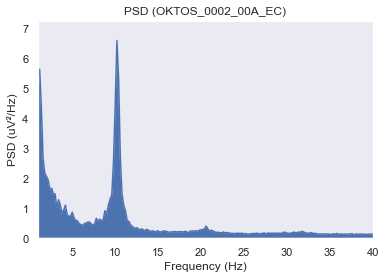

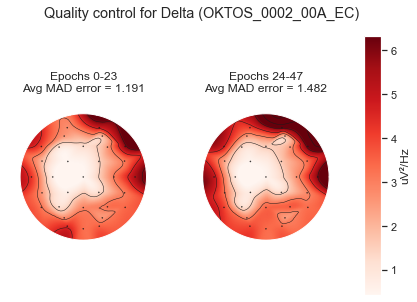

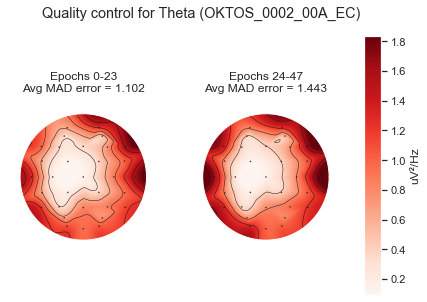

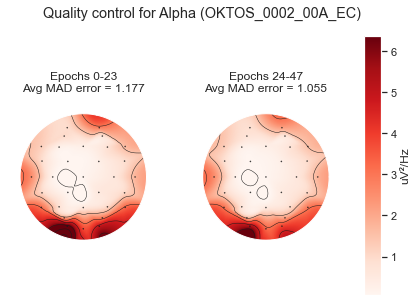

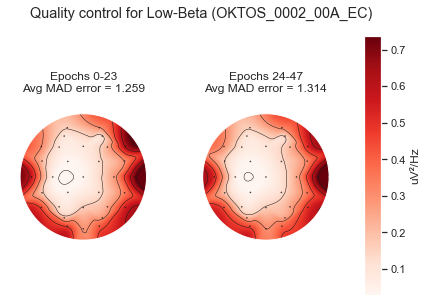

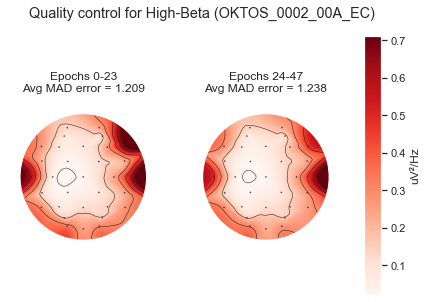

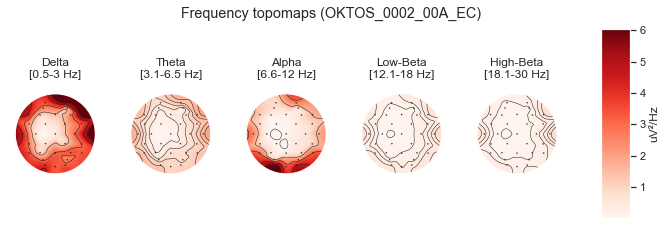

In [8]:
df_psd_delta = pd.DataFrame()
df_psd_theta = pd.DataFrame()
df_psd_alpha = pd.DataFrame()
df_psd_lowbeta = pd.DataFrame()
df_psd_highbeta = pd.DataFrame()

# Go through all the files (subjects) in the folder
for i in range(len(file_dirs)):

    # Read the clean data from the disk
    epochs = mne.read_epochs(fname='{}\{}_clean-epo.fif'.format(dir_inprogress,subject_names[i]))

    # Calculate Welch's power spectrum density
    [psds,freqs] = calculatePSD(epochs,subject_names[i],epo_duration=5)

    # Find bandpowers and add them to existing dataframes including other subjects
    psd_delta_ch = bandpowerPerChannel(psds,freqs,[0.5,3],"Delta",subject_names[i],epochs)
    df_psd_delta_temp = arrayToDataframe(subject_names[i],epochs,psd_delta_ch)
    df_psd_delta = pd.concat([df_psd_delta,df_psd_delta_temp])

    psd_theta_ch = bandpowerPerChannel(psds,freqs,[3.1,6.5],"Theta",subject_names[i],epochs)
    df_psd_theta_temp = arrayToDataframe(subject_names[i],epochs,psd_theta_ch)
    df_psd_theta = pd.concat([df_psd_theta,df_psd_theta_temp])

    psd_alpha_ch = bandpowerPerChannel(psds,freqs,[6.6,12],"Alpha",subject_names[i],epochs)
    df_psd_alpha_temp = arrayToDataframe(subject_names[i],epochs,psd_alpha_ch)
    df_psd_alpha = pd.concat([df_psd_alpha,df_psd_alpha_temp])

    psd_lowbeta_ch = bandpowerPerChannel(psds,freqs,[12.1,18],"Low-Beta",subject_names[i],epochs)
    df_psd_lowbeta_temp = arrayToDataframe(subject_names[i],epochs,psd_lowbeta_ch)
    df_psd_lowbeta = pd.concat([df_psd_lowbeta,df_psd_lowbeta_temp])

    psd_highbeta_ch = bandpowerPerChannel(psds,freqs,[18.1,30],"High-Beta",subject_names[i],epochs)
    df_psd_highbeta_temp = arrayToDataframe(subject_names[i],epochs,psd_highbeta_ch)
    df_psd_highbeta = pd.concat([df_psd_highbeta,df_psd_highbeta_temp])

    # Plot topomaps for all the bands
    vmin = min([min(psd_delta_ch),min(psd_theta_ch),min(psd_alpha_ch),
                min(psd_lowbeta_ch),min(psd_highbeta_ch)])
    vmax = max([max(psd_delta_ch),max(psd_theta_ch),max(psd_alpha_ch),
                max(psd_lowbeta_ch),max(psd_highbeta_ch)])

    sns.set()
    fig,(ax1,ax2,ax3,ax4,ax5) = plt.subplots(nrows=1,ncols=5,figsize=(10,3))
    fig.suptitle("Frequency topomaps ({})".format(subject_names[i]),y=1.1,x=0.575)
    im,cm = mne.viz.plot_topomap(psd_delta_ch,epochs.info,axes=ax1,vmin=vmin,vmax=vmax,show=False)
    im,cm = mne.viz.plot_topomap(psd_theta_ch,epochs.info,axes=ax2,vmin=vmin,vmax=vmax,show=False)
    im,cm = mne.viz.plot_topomap(psd_alpha_ch,epochs.info,axes=ax3,vmin=vmin,vmax=vmax,show=False)
    im,cm = mne.viz.plot_topomap(psd_lowbeta_ch,epochs.info,axes=ax4,vmin=vmin,vmax=vmax,show=False)
    im,cm = mne.viz.plot_topomap(psd_highbeta_ch,epochs.info,axes=ax5,vmin=vmin,vmax=vmax,show=False)
    ax1.set_title("Delta\n[0.5-3 Hz]")
    ax2.set_title("Theta\n[3.1-6.5 Hz]")
    ax3.set_title("Alpha\n[6.6-12 Hz]")
    ax4.set_title("Low-Beta\n[12.1-18 Hz]")
    ax5.set_title("High-Beta\n[18.1-30 Hz]")
    ax_x_start = 0.95
    ax_x_width = 0.04
    ax_y_start = 0.125
    ax_y_height = 0.875
    cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
    clb = fig.colorbar(im, cax=cbar_ax)
    clb.ax.set_ylabel('uV\u00b2/Hz')

try:
    os.makedirs(os.path.join(r"Results\PSD\channels",exp_folder))
except FileExistsError:
    pass

df_psd_delta.to_excel(r"Results\PSD\channels\{}\{}_psd_delta.xlsx".format(exp_folder,exp_condition))
df_psd_theta.to_excel(r"Results\PSD\channels\{}\{}_psd_theta.xlsx".format(exp_folder,exp_condition))
df_psd_alpha.to_excel(r"Results\PSD\channels\{}\{}_psd_alpha.xlsx".format(exp_folder,exp_condition))
df_psd_lowbeta.to_excel(r"Results\PSD\channels\{}\{}_psd_lowbeta.xlsx".format(exp_folder,exp_condition))
df_psd_highbeta.to_excel(r"Results\PSD\channels\{}\{}_psd_highbeta.xlsx".format(exp_folder,exp_condition))

df_psd_delta_regional = channelsToRegions(df_psd_delta)
df_psd_theta_regional = channelsToRegions(df_psd_theta)
df_psd_alpha_regional = channelsToRegions(df_psd_alpha)
df_psd_lowbeta_regional = channelsToRegions(df_psd_lowbeta)
df_psd_highbeta_regional = channelsToRegions(df_psd_highbeta)

try:
    os.makedirs(os.path.join(r"Results\PSD\regions",exp_folder))
except FileExistsError:
    pass

df_psd_delta_regional.to_excel(r"Results\PSD\regions\{}\{}_psd_delta.xlsx".format(exp_folder,exp_condition))
df_psd_theta_regional.to_excel(r"Results\PSD\regions\{}\{}_psd_theta.xlsx".format(exp_folder,exp_condition))
df_psd_alpha_regional.to_excel(r"Results\PSD\regions\{}\{}_psd_alpha.xlsx".format(exp_folder,exp_condition))
df_psd_lowbeta_regional.to_excel(r"Results\PSD\regions\{}\{}_psd_lowbeta.xlsx".format(exp_folder,exp_condition))
df_psd_highbeta_regional.to_excel(r"Results\PSD\regions\{}\{}_psd_highbeta.xlsx".format(exp_folder,exp_condition))
